In [2]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import importlib

import seaborn as sns

In [3]:
save_plots = False

## Synthetic Example

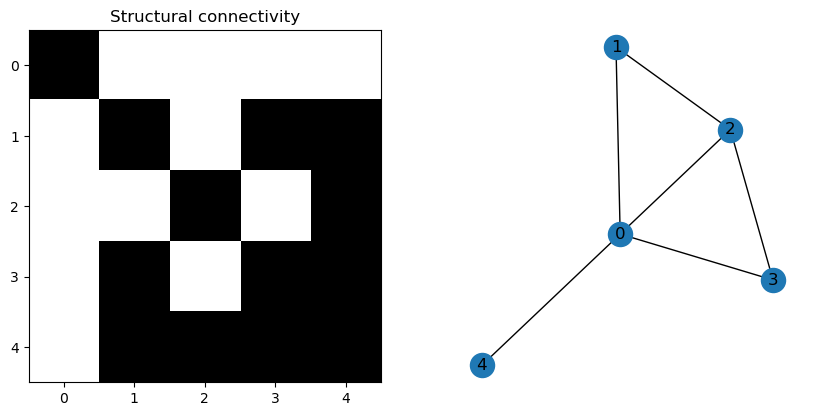

In [4]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

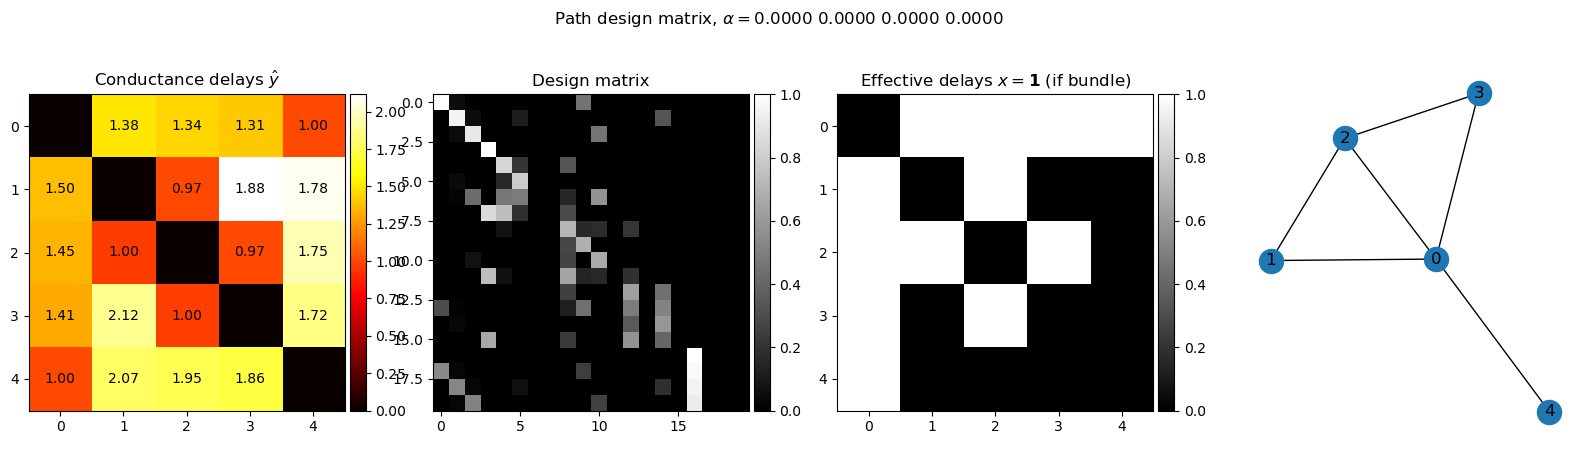

In [22]:
importlib.reload(regmod)

max_path_depth = 4

# multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

# design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
a = np.arange(0, 20, 1)/20
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Initialization with pseudo-inverse + iterative optimization

In [23]:
max_path_depth = 4

a = 0
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

a = np.arange(0, 20, 1)/20
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

x_ground = utils.remove_diagonal_entries(adj).flatten()

alpha = solver.torch.tensor(alpha)

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())

y_ground = solver.torch.tensor(utils.deepcopy(y_pred))
init_pseudo = False
if init_pseudo:
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

# alphas_init = solver.torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_84288/3652455933.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [26]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=20000, verbose=False, early_stop=1e-10, step_size=1e-2)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0208'}>)

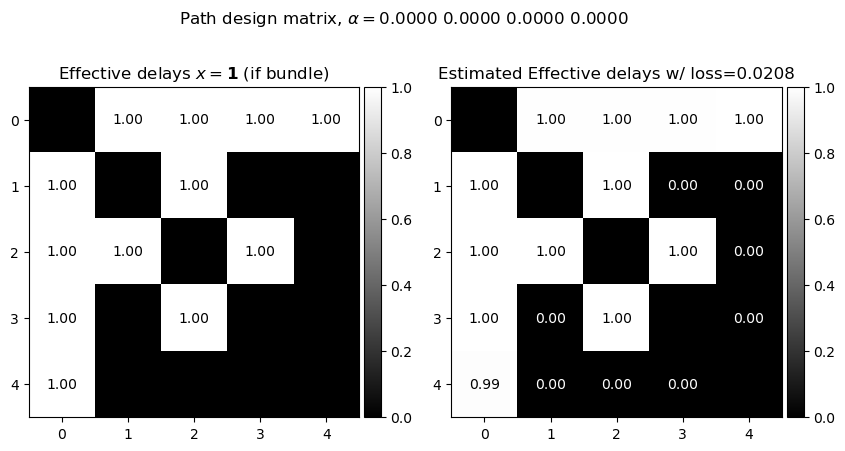

In [27]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# NOTE: we need to rechek this, it seems that the colors are flipped? (transposed?)
utils.annotate_heatmap(fig, axes[1], x_pred_mat.T, adapt_color=0.6)

## F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

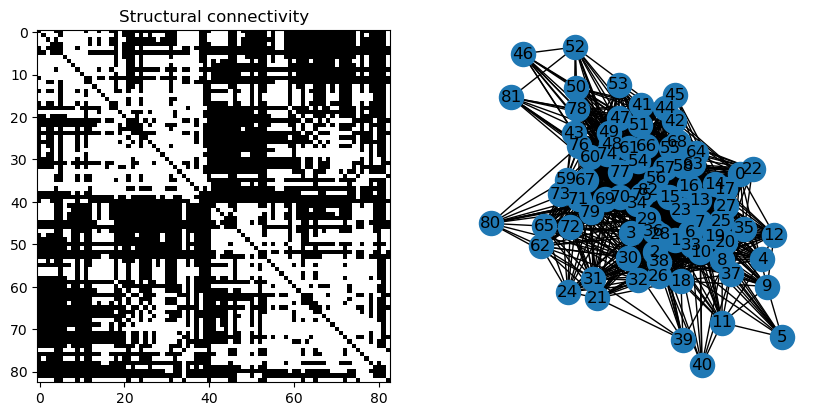

In [5]:
path_to_data = "../resources"

# Could be 50, 100, 200, 400
delay_max = 400
#path_to_ftract = f"../../atlas_data/F-TRACT-090624/{delay_max}"
path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay_max}"
path_to_ftract_compare = op.join(path_to_ftract, f"../{100}")

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))

adj = adj[:83, :83]
adj -= np.diag(np.diag(adj))

bundle_prob_thresh = 0.9

adj = (adj > bundle_prob_thresh).astype(int)

bundle_prob = utils.load(op.join(path_to_data, "bundle_probability_atlas.pkl"))
bundle_prob = bundle_prob[:83, :83]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, "adj_probability_ftract.pkl"))
ftract_prob = ftract_prob[:83, :83]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

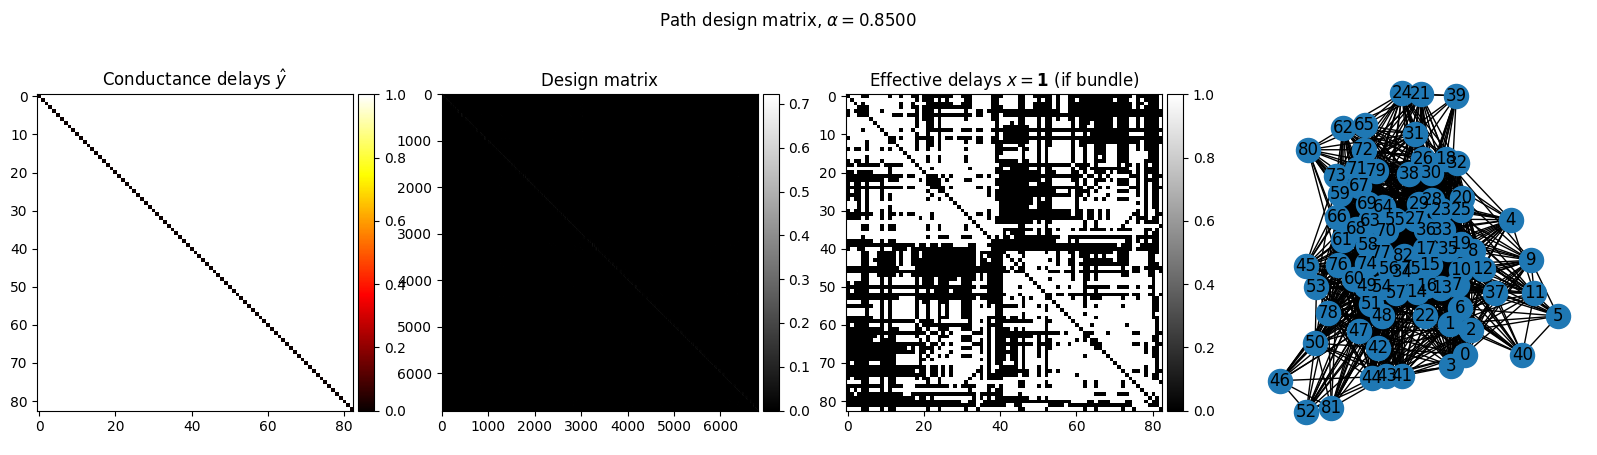

In [54]:
max_path_depth = 3

#multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

#a = 0
# Computes the alpha vector as alpha_n = a^n
#alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

#design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=0.5)

y_pred_mat = regmod.predict_conduction_delays(design_shortest, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot', interpolation=None)
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
#utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_shortest, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check

In [22]:
reduced_adj = deepcopy(adj)

x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()

a = 0.5
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)

design_shortest = regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)
x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [23]:
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
y_ground = solver.torch.tensor(utils.deepcopy(y_pred))

init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_25245/2463974400.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [24]:
## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [25]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=5000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-2,
                                            l2_penalty=5e-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0302'}>)

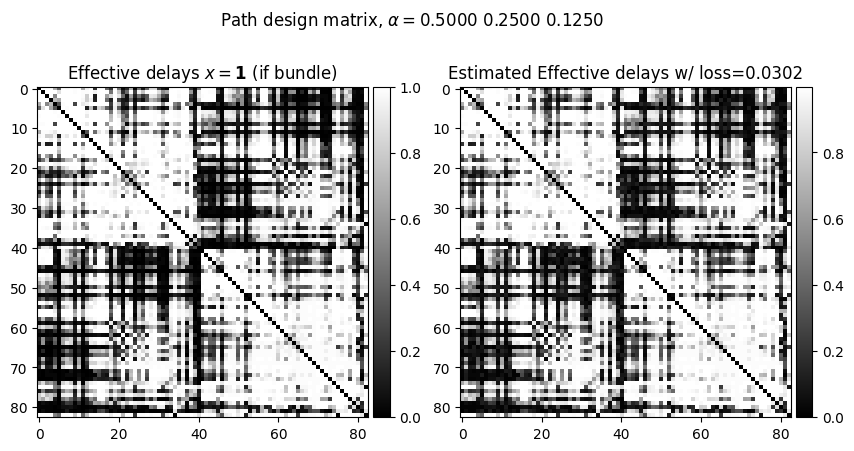

In [26]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 0, 'Delay differences')

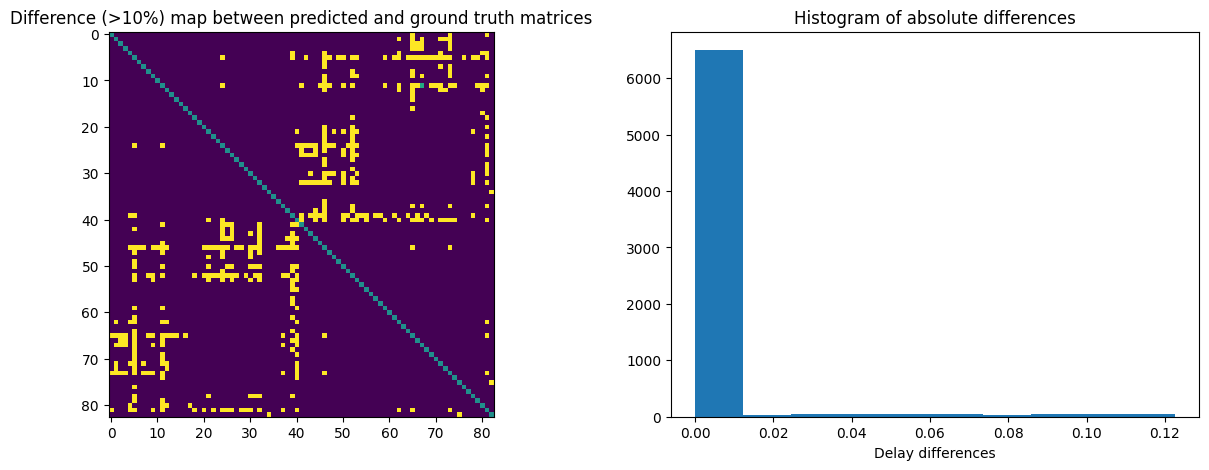

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax[0].imshow(x_pred_mat - x_ground_mat, vmin=-1e-5, vmax=1e-5)
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(x_pred_mat - x_ground_mat).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

### From conductance delay

In [6]:
# conductance delay to regress
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

with open(op.join(path_to_ftract_compare, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat_compare = []
for t in text[8:]:
    y_ground_mat_compare.append(t.split(' '))
y_ground_mat_compare = np.array(y_ground_mat_compare).astype(float)
y_ground_mat_compare = np.nan_to_num(y_ground_mat_compare[:-1, :-1])

prob_thresh = 0
y_ground_mat_compare *= ftract_prob > prob_thresh
y_ground_compare = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat_compare).flatten())

In [11]:
importlib.reload(regmod)
max_path_depth = 1

#design_shortest = regmod.build_design_shortest(adj, n_subopt=max_path_depth, alpha=a)
design_matrices = regmod.get_shortest_matrices(adj, max_path_depth, progress=True)

  0%|          | 0/6806 [00:00<?, ?it/s]

In [16]:
a = 0.8
a = np.arange(0, design_matrices.shape[1], 1)/design_matrices.shape[1]
design_shortest = regmod.apply_alpha_to_design(design_matrix=design_matrices, n_subopt=max_path_depth, alpha=a)
design_model = solver.torch.tensor(design_shortest)

non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [17]:
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Effective delays $x$ (loss=0.692 ms/edge)'}>)

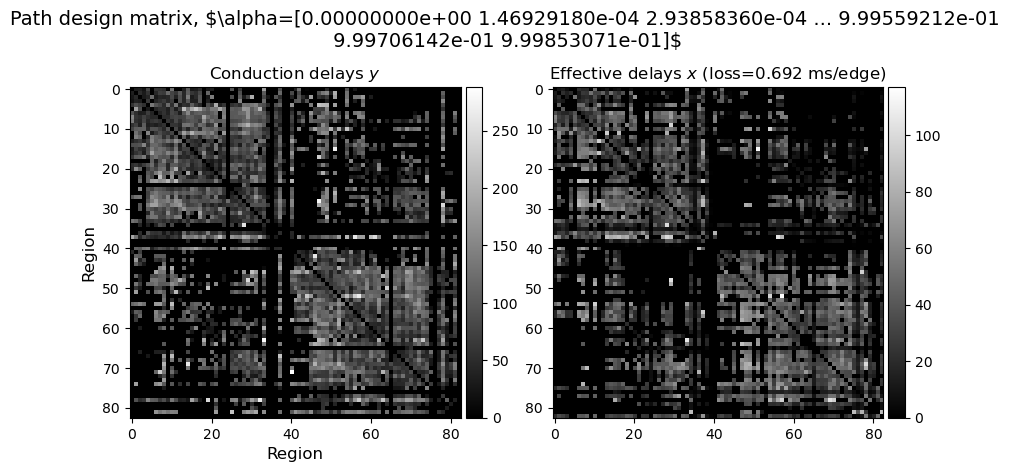

In [18]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Effective delays $x$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

#axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
#axes[2].set_title(f"Clipped $\hat y$")
#utils.add_cbar(fig, axes[2])

# if save_plots:
#     fig.savefig(f"../figures/estimated_delays_a{a}.png", dpi=300)

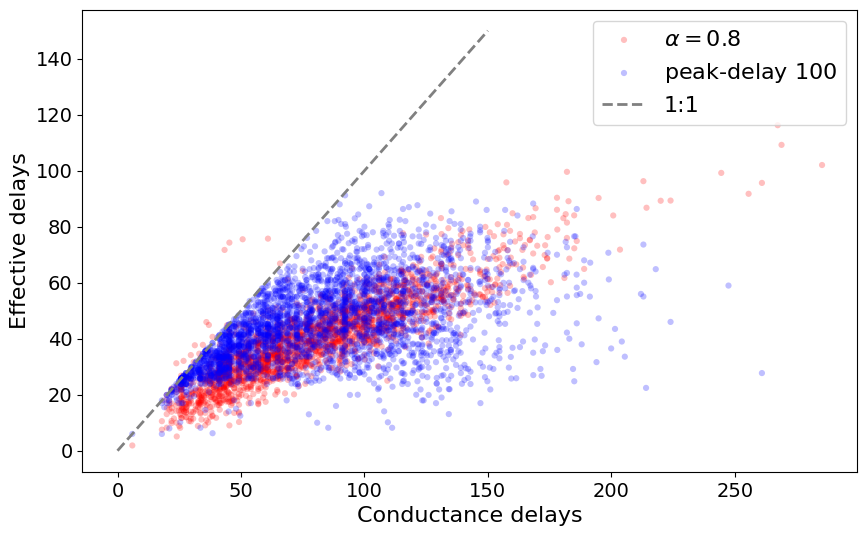

In [26]:
# plot the mapping curve and see what it looks like
x1 = x_opt
x2 = y_ground_compare
y = y_ground

x1_mask = x1 > 1
x2_mask = x2 > 1
y_mask = y != 0
xy_mask1 = np.logical_and(x1_mask, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x2_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=20, alpha=.25, edgecolors="none", color='red', label=r'$\alpha=0.8$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=20, alpha=.25, edgecolors="none", color='blue', label=r'peak-delay $100$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

# Visualize when including $\delta$

In [37]:
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

with open('../resources/speed__fibres__dcm_axonal_delay__median.txt') as f:
    text = f.readlines()

y_ground_mat_compare = []
for t in text[8:]:
    y_ground_mat_compare.append(t.split(' '))
y_ground_mat_compare = np.array(y_ground_mat_compare).astype(float)
y_ground_mat_compare = np.nan_to_num(y_ground_mat_compare[:-1, :-1])

prob_thresh = 0
y_ground_mat_compare *= ftract_prob > prob_thresh
y_ground_compare = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat_compare).flatten())

In [38]:
max_path_depth = 1
a = 0.8

design_shortest = regmod.build_design_shortest(adj, n_subopt=max_path_depth, alpha=a)
design_model = solver.torch.tensor(design_shortest)

non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [39]:
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=30,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Effective delays $x$ (loss=0.7234 ms/edge)'}>)

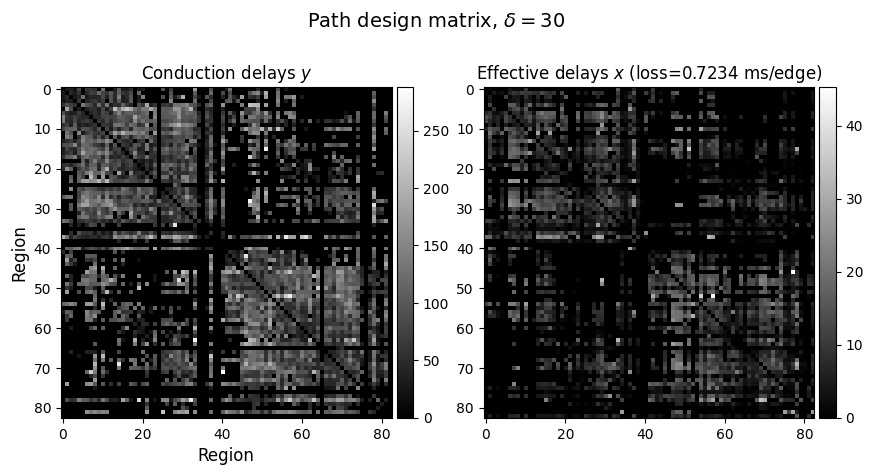

In [40]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\delta={30}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Effective delays $x$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

#axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
#axes[2].set_title(f"Clipped $\hat y$")
#utils.add_cbar(fig, axes[2])

# if save_plots:
#     fig.savefig(f"../figures/estimated_delays_a{a}.png", dpi=300)

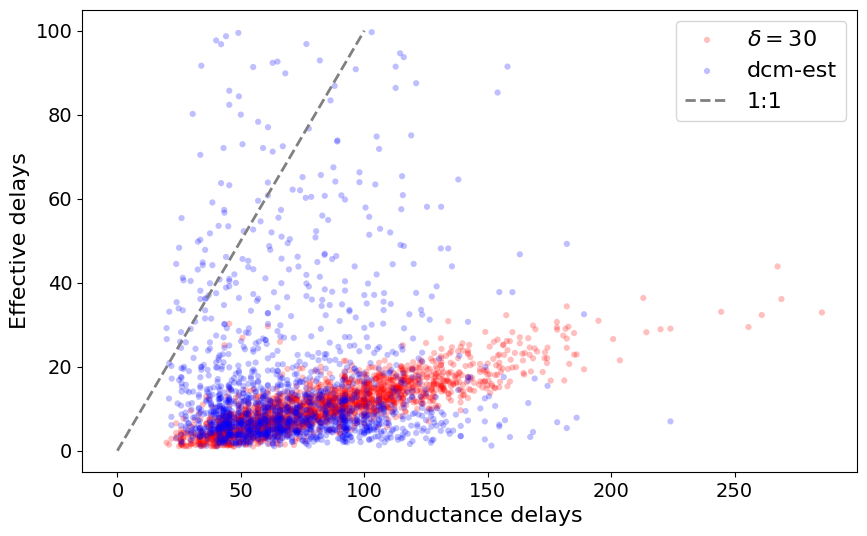

In [43]:
# plot the mapping curve and see what it looks like
x1 = x_opt
x2 = y_ground_compare
y = y_ground

x1_mask = x1 > 1
x2_mask = (x2 > 1) & (x2 < 100)
y_mask = y != 0
xy_mask1 = np.logical_and(x1_mask, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x2_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=20, alpha=.25, edgecolors="none", color='red', label=r'$\delta=30$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=20, alpha=.25, edgecolors="none", color='blue', label=r'dcm-est')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,100), np.linspace(0,100), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
# ax.legend(["Non-zero"], fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)